In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans

from wordcloud import WordCloud, ImageColorGenerator

In [2]:
ls data

CUAD_v1.json        CUAD_v1_README.txt  full_contract_txt/  master_clauses.csv


In [2]:
cla_df = pd.read_csv('data/master_clauses.csv')

In [3]:
cla_df.head()

,Filename,Document Name,Document Name-Answer,Parties,Parties-Answer,Agreement Date,Agreement Date-Answer,Effective Date,Effective Date-Answer,Expiration Date,...,Liquidated Damages,Liquidated Damages-Answer,Warranty Duration,Warranty Duration-Answer,Insurance,Insurance-Answer,Covenant Not To Sue,Covenant Not To Sue-Answer,Third Party Beneficiary,Third Party Beneficiary-Answer
0,CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...,['MARKETING AFFILIATE AGREEMENT'],MARKETING AFFILIATE AGREEMENT,"['BIRCH FIRST GLOBAL INVESTMENTS INC.', 'MA', ...","Birch First Global Investments Inc. (""Company""...","['8th day of May 2014', 'May 8, 2014']",5/8/14,['This agreement shall begin upon the date of ...,NaN,['This agreement shall begin upon the date of ...,...,[],No,"[""COMPANY'S SOLE AND EXCLUSIVE LIABILITY FOR T...",Yes,[],No,[],No,[],No
1,EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...,['VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT'],VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT,"['EuroMedia Holdings Corp.', 'Rogers', 'Rogers...","Rogers Cable Communications Inc. (""Rogers""); E...","['July 11 , 2006']",7/11/06,"['July 11 , 2006']",7/11/06,"['The term of this Agreement (the ""Initial Ter...",...,[],No,[],No,[],No,[],No,[],No
2,FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...,['CONTENT DISTRIBUTION AND LICENSE AGREEMENT'],CONTENT DISTRIBUTION AND LICENSE AGREEMENT,"['Producer', 'Fulucai Productions Ltd.', 'Conv...","CONVERGTV, INC. (“ConvergTV”); Fulucai Product...","['November 15, 2012']",11/15/12,"['November 15, 2012']",11/15/12,[],...,[],No,[],No,[],No,[],No,[],No
3,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,['WEBSITE CONTENT LICENSE AGREEMENT'],WEBSITE CONTENT LICENSE AGREEMENT,"['PSiTech Corporation', 'Licensor', 'Licensee'...","PSiTech Corporation (""Licensor""); Empirical Ve...","['Feb 10, 2014']",2/10/14,"['Feb 10, 2014']",2/10/14,['The initial term of this Agreement commences...,...,[],No,[],No,[],No,[],No,[],No
4,IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...,['CONTENT LICENSE AGREEMENT'],CONTENT LICENSE AGREEMENT,"['YOU ON DEMAND HOLDINGS, INC.', 'Licensor', '...",Beijing Sun Seven Stars Culture Development Li...,"['December 21, 2015']",12/21/15,"['December 21, 2015']",12/21/15,"['The Term of this Agreement (the ""Term"") shal...",...,[],No,[],No,[],No,[],No,[],No


In [4]:
contract_types = cla_df[['Filename','Document Name-Answer']].copy()
contract_types['Contract type'] = contract_types['Document Name-Answer'].str.capitalize()
contract_types.drop('Document Name-Answer', axis=1, inplace=True)
# contract_types['Filename'] = contract_types['Filename'].str.replace('.PDF','.txt', case=False, regex=True)
contract_types['Filename'] = contract_types['Filename'].str[:-4]
contract_types['Filename'] = contract_types['Filename'].str.replace('&','_', case=False, regex=True)
contract_types['Filename'] = contract_types['Filename'].str.strip()
contract_types

,Filename,Contract type
0,CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...,Marketing affiliate agreement
1,EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...,Video-on-demand content license agreement
2,FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...,Content distribution and license agreement
3,GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...,Website content license agreement
4,IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...,Content license agreement
...,...,...
505,NEONSYSTEMSINC_03_01_1999-EX-10.5-DISTRIBUTOR ...,Distributor agreement
506,WOMENSGOLFUNLIMITEDINC_03_29_2000-EX-10.13-END...,Endorsement agreement
507,WOMENSGOLFUNLIMITEDINC_03_29_2000-EX-10.13-END...,Intellectual property rights c...
508,"KUBIENT,INC_07_02_2020-EX-10.14-MASTER SERVICE...",Exhibit ‘b’


In [5]:
len(contract_types['Filename'])

510

## EDA

In [6]:
contract_types_grouped = contract_types.groupby(['Contract type']).count()['Filename'].sort_values(ascending=True)

In [7]:
contract_types_grouped

Contract type
                            content license agreement     1
Master services agreement                                 1
Master services agreement (                               1
Media content and license agreement                       1
Media license agreement                                   1
                                                         ..
Distributor agreement                                    13
Intellectual property agreement                          14
Endorsement agreement                                    17
Sponsorship agreement                                    25
Strategic alliance agreement                             28
Name: Filename, Length: 258, dtype: int64

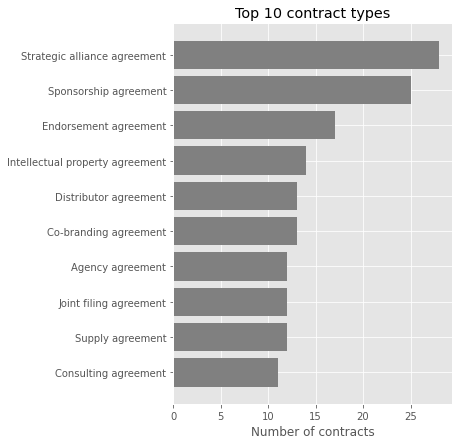

In [11]:
fig, ax = plt.subplots(figsize=(5,7))
ax.barh(contract_types_grouped.index[-10:], contract_types_grouped[-10:], color='grey')
ax.set_title('Top 10 contract types')
ax.set_xlabel('Number of contracts');

In [64]:
# cla_df.info()

In [345]:
#set maximum column width for dataframes
pd.set_option('display.max_colwidth', 100)

## Read full contract texts to list

In [13]:
def read_contracts(folder):
    contracts = []
    files = []
    for file in os.listdir(folder):
        fullpath = folder + '/' + file
        with open(fullpath) as f:
            contracts.append(f.read())
            files.append(file)
    return files, contracts

In [14]:
folder = 'data/full_contract_txt'
files, contracts = read_contracts(folder)

In [15]:
len(contracts)

510

In [16]:
files[0]

'LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT.txt'

In [17]:
contracts[0]

'EXHIBIT 10.6\n\n                              DISTRIBUTOR AGREEMENT\n\n         THIS  DISTRIBUTOR  AGREEMENT (the  "Agreement")  is made by and between Electric City Corp.,  a Delaware  corporation  ("Company")  and Electric City of Illinois LLC ("Distributor") this 7th day of September, 1999.\n\n                                    RECITALS\n\n         A. The  Company\'s  Business.  The Company is  presently  engaged in the business  of selling an energy  efficiency  device,  which is  referred to as an "Energy  Saver"  which may be improved  or  otherwise  changed  from its present composition (the "Products").  The Company may engage in the business of selling other  products  or  other  devices  other  than  the  Products,  which  will be considered  Products if Distributor  exercises its options pursuant to Section 7 hereof.\n\n         B. Representations.  As an inducement to the Company to enter into this Agreement,  the  Distributor  has  represented  that  it has or  will  hav

In [18]:
contracts_dict = {'Filename': files, 'contract_text': contracts}

In [19]:
contracts_df_base = pd.DataFrame(contracts_dict)
contracts_df_base['Filename'] = contracts_df_base['Filename'].str[:-4]
contracts_df_base['Filename'] = contracts_df_base['Filename'].str.strip()
contracts_df_base.head()

,Filename,contract_text
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,EXHIBIT 10.6\n\n ...
1,"WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION A...",Exhibit 10.26 CONFIDENTIAL TREATMENT HAS BE...
2,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,Exhibit 10.16 SUPPLY CONTRACT Contract No: Dat...
3,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...,1 ...
4,NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT,Exhibit 1\n\nJOINT FILING AGREEMENT\n\nThe und...


### Merging contract types to contract dataframe and checking mismatches in file names

In [20]:
contracts_df = pd.merge(contracts_df_base, contract_types, on='Filename', how='left')

In [21]:
contracts_df.head()

,Filename,contract_text,Contract type
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,EXHIBIT 10.6\n\n ...,Distributor agreement
1,"WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION A...",Exhibit 10.26 CONFIDENTIAL TREATMENT HAS BE...,Promotion and distribution agreement
2,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,Exhibit 10.16 SUPPLY CONTRACT Contract No: Dat...,Supply contract
3,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...,1 ...,Web site hosting agreement
4,NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT,Exhibit 1\n\nJOINT FILING AGREEMENT\n\nThe und...,Joint filing agreement


In [22]:
contracts_df[contracts_df['Contract type'].isna()]

,Filename,contract_text,Contract type
88,"NETGEAR,INC_04_21_2003-EX-10.16-AMENDMENT TO T...",term under the Agreement will not be effective...,NaN
282,KALLOINC_11_03_2011-EX-10.1-STRATEGIC ALLIANCE...,Exhibit 10.1\n\nKALLO Inc.\n\n\n\nSTRATEGIC AL...,NaN
454,"MACY_S,INC_05_11_2020-EX-99.4-JOINT FILING AGR...",Exhibit 99.4 JOINT FILING AGREEMENT In accorda...,NaN


In [23]:
A = contracts_df.loc[88,'Filename']
A

'NETGEAR,INC_04_21_2003-EX-10.16-AMENDMENT TO THE DISTRIBUTOR AGREEMENT BETWEEN INGRAM MICRO AND NETGEAR'

In [24]:
contract_types[contract_types['Filename'].str.contains('NETGEAR,INC_04_21_2003-EX')]

,Filename,Contract type
501,"NETGEAR,INC_04_21_2003-EX-10.16-AMENDMENT TO T...",Amendment ...
502,"NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AG...",Distributor agreement
503,"NETGEAR,INC_04_21_2003-EX-10.16- AMENDMENT #2 ...",Amendment #2 to the ...


In [25]:
B = contract_types.loc[501,'Filename']
B

'NETGEAR,INC_04_21_2003-EX-10.16-AMENDMENT TO THE DISTRIBUTOR AGREEMENT BETWEEN INGRAM MICRO AND NETGEAR-'

In [26]:
len(A), len(B), type(A), type(B), A==B

(103, 104, str, str, False)

In [27]:
import difflib
output_list = [li for li in difflib.ndiff(A, B) if li[0] != ' ']
output_list

['+ -']

In [28]:
contracts_df_clean = contracts_df.dropna()

## TF-IDF with sklearn

In [29]:
tfidf = TfidfVectorizer(stop_words='english', 
                                token_pattern='[A-Za-z]+', 
                                ngram_range=(1, 1),
                                min_df=3)

tfidf_values = tfidf.fit_transform(contracts)

In [30]:
contracts_tfidf = pd.DataFrame(tfidf_values.toarray(), columns=tfidf.get_feature_names())

In [31]:
contracts_tfidf.insert(loc=0, column = 'Filename', value = files)
contracts_tfidf.insert(loc=1, column = 'Contract type', value = contracts_df['Contract type'])

In [32]:
contracts_tfidf

,Filename,Contract type,aa,aaa,ab,aba,abandon,abandoned,abandoning,abandonment,...,zealand,zero,zhang,zip,zl,zone,zones,zoning,zuzelo,zz
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Distributor agreement,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION A...",Promotion and distribution agreement,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,Supply contract,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...,Web site hosting agreement,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEME...,Joint filing agreement,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,XinhuaSportsEntertainmentLtd_20070221_F-1_EX-9...,content license ag...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
506,MERITLIFEINSURANCECO_06_19_2020-EX-10.(XIV)-MA...,Master services agreement (,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,"TALLGRASSENERGY,LP_02_20_2020-EX-99.26-JOINT F...",Joint filing agreement,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508,KINGPHARMACEUTICALSINC_08_09_2006-EX-10.1-PROM...,Promotion agreement,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.001786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
contracts_tfidf.dropna(inplace=True)

### Search term based on top 10 document

In [34]:
search_term = 'venture'
contracts_tfidf.sort_values(search_term, ascending=False)[['Contract type', search_term]][:10]

,Contract type,venture
25,Joint venture agreement,0.445069
238,Joint venture contract,0.440877
415,Joint venture agreement,0.397925
225,Joint venture agreemen,0.359903
150,Joint venture agreement,0.310664
288,Marketing agreement,0.180930
501,Joint venture agreement,0.097179
7,Amendment and termination \n\nof \n\njoint ven...,0.067807
463,Joint venture agreement,0.054109
287,Strategic alliance agreement,0.052032


## Unsupervised text clustering

In [35]:
X = contracts_tfidf.drop(['Filename','Contract type'], axis=1)
X.head()

,aa,aaa,ab,aba,abandon,abandoned,abandoning,abandonment,abate,abatement,...,zealand,zero,zhang,zip,zl,zone,zones,zoning,zuzelo,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


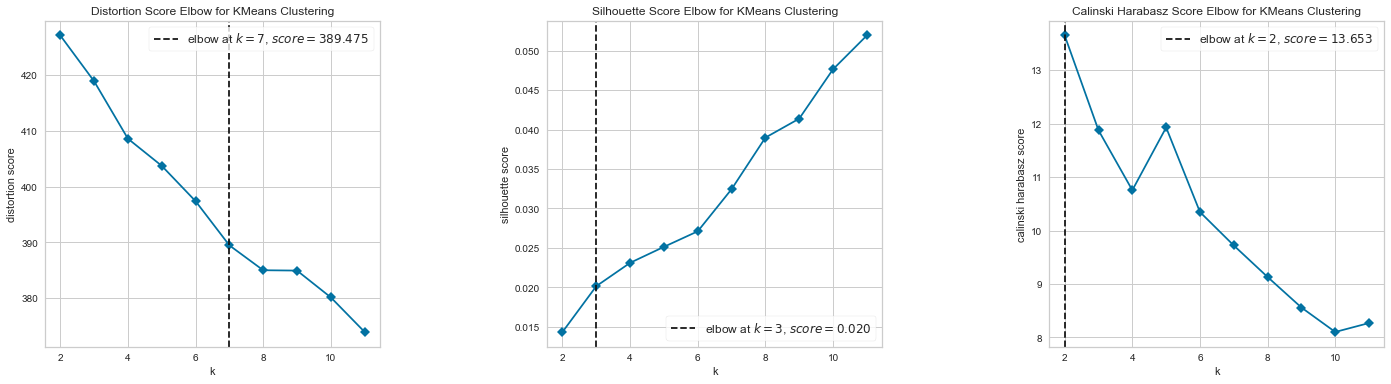

In [52]:
from yellowbrick.cluster import KElbowVisualizer
fig, ax = plt.subplots(1,3, figsize = (24,6))
plt.subplots_adjust(wspace=0.5)


for ax_idx, metric in enumerate(['distortion', 'silhouette', 'calinski_harabasz']):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,12), metric=metric, ax=ax[ax_idx], timings=False)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.finalize()        # Finalize and render the figure

In [37]:
km = KMeans(5)
km.fit(X)
y_predicted = km.predict(X)

In [38]:
y_predicted

array([2, 2, 3, 1, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 1,
       4, 1, 4, 3, 3, 4, 3, 3, 3, 1, 4, 3, 4, 1, 3, 1, 3, 4, 3, 4, 0, 4,
       3, 3, 3, 3, 3, 1, 4, 3, 3, 3, 4, 3, 4, 1, 3, 4, 1, 4, 1, 3, 3, 3,
       3, 2, 3, 4, 3, 4, 4, 3, 3, 4, 4, 4, 3, 3, 4, 1, 3, 4, 3, 4, 3, 1,
       4, 3, 1, 0, 3, 4, 3, 3, 4, 3, 1, 1, 2, 3, 3, 1, 3, 3, 4, 4, 1, 3,
       3, 3, 4, 3, 4, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 4, 3, 4, 4, 4, 3, 4,
       1, 2, 3, 2, 3, 3, 3, 1, 3, 3, 4, 4, 3, 3, 1, 3, 4, 4, 3, 4, 2, 1,
       2, 3, 4, 4, 4, 3, 4, 3, 4, 2, 1, 3, 2, 4, 3, 3, 3, 4, 0, 4, 1, 3,
       3, 3, 1, 3, 3, 4, 4, 1, 0, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 1, 2,
       3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 0, 3, 3, 0, 3, 2, 0, 3, 4, 3,
       3, 4, 1, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 4, 2, 4, 4,
       4, 3, 4, 4, 2, 3, 3, 1, 4, 3, 1, 4, 3, 3, 4, 4, 3, 2, 4, 4, 4, 3,
       2, 4, 4, 4, 3, 4, 4, 4, 1, 3, 4, 0, 4, 3, 1, 4, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 4, 3, 3, 3, 3, 3, 2, 4, 1, 3, 3, 4,

In [39]:
y_predicted.shape

(507,)

In [42]:
contracts_df_clean['KMeans_pred'] = y_predicted

<ipython-input-42-0b89856b5b79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contracts_df_clean['KMeans_pred'] = y_predicted


In [43]:
contracts_df_clean.head()

,Filename,contract_text,Contract type,KMeans_pred
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,EXHIBIT 10.6\n\n ...,Distributor agreement,2
1,"WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION A...",Exhibit 10.26 CONFIDENTIAL TREATMENT HAS BE...,Promotion and distribution agreement,2
2,LohaCompanyltd_20191209_F-1_EX-10.16_11917878_...,Exhibit 10.16 SUPPLY CONTRACT Contract No: Dat...,Supply contract,3
3,CENTRACKINTERNATIONALINC_10_29_1999-EX-10.3-WE...,1 ...,Web site hosting agreement,1
4,NELNETINC_04_08_2020-EX-1-JOINT FILING AGREEMENT,Exhibit 1\n\nJOINT FILING AGREEMENT\n\nThe und...,Joint filing agreement,3


In [441]:
# contracts_df_clean.groupby(['KMeans_pred', 'Contract type']).count()

In [44]:
#set maximum column width for dataframes
pd.set_option('display.max_rows', None)
pd.pivot_table(contracts_df_clean, index=['Contract type'], columns=['KMeans_pred'], aggfunc=len, fill_value=0)['Filename'].sort_values(by=[0,1,2,3,4], ascending=False)

KMeans_pred,0,1,2,3,4
Contract type,,,,,
Co-branding agreement,8,0,0,3,2
Sponsorship agreement,6,2,0,14,3
Co-branding agreement (form),1,0,0,0,0
Co-branding content agreement,1,0,0,0,0
Outsourcing agreement,0,4,0,4,1
Reseller agreement,0,4,0,1,1
Strategic alliance agreement,0,2,0,13,12
Maintenance agreement,0,2,0,1,1
License and hosting agreement,0,2,0,1,0


### Create word clouds

In [45]:
contracts_tfidf.insert(loc=0, column='KMeans_cluster', value=y_predicted)

In [46]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(tfidf_values.toarray()).flatten()[::-1]

n = 200
top_n = feature_array[tfidf_sorting][:n]

In [47]:
top_words = ' '.join(top_n)
top_words

'north company shall s endorsed appearance sports appearances endorsement agreement brands advertising likeness production contract golf usd use materials product promotional agrees thousand guaranteed bag year woods february source f page performance set fidelity forth dollars disapproved party period orlando hereinafter branded products duration events hereunder manhattan aftra sag fee term voice royalties beach make television additional reasonable insurance public mean putter putters testimonial said referred parties expenses retainer photographs blvd whatsoever airline approximately debts scheduled days rights hours packaging b default services including assessments llc advertisement clubs thereof following apparel photograph illegible g territory pay group demonstration event personal paragraph c times n paid right contravention remedies written fl ca fees force wear majeure payment sale ii approval producing trial incorporated termination michael choice compensation uncured quar

In [50]:
wc = WordCloud(width=600, height=600, background_color='lightgrey').generate_from_text(top_words)

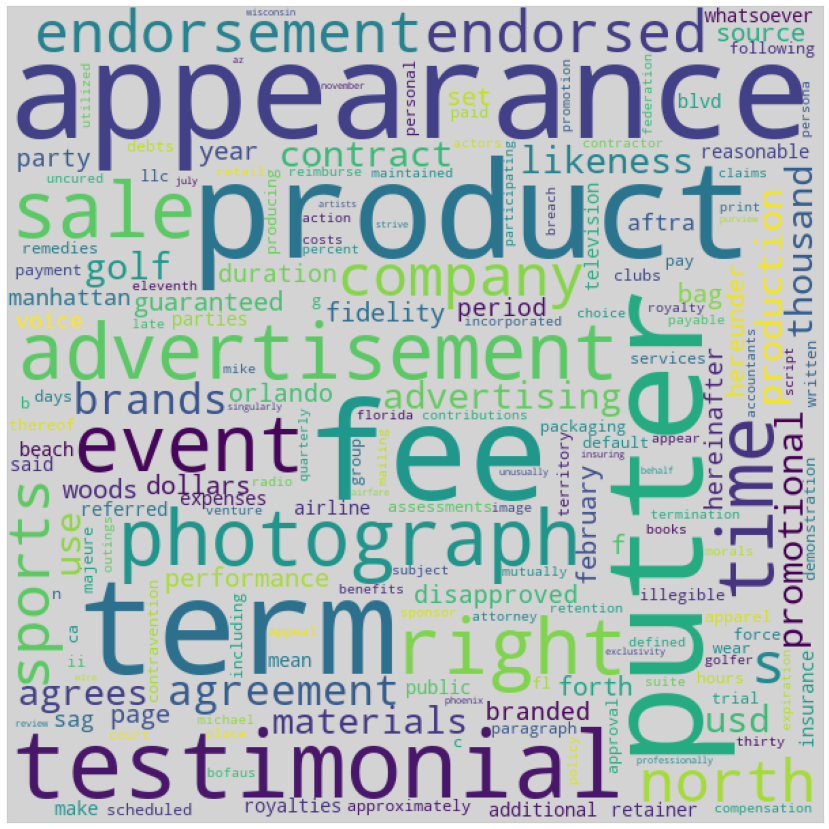

In [51]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(wc)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([]);